# New York taxis trips

This homework is about New York taxi trips. Here is something from [Todd Schneider](https://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/):

> The New York City Taxi & Limousine Commission has released a  detailed historical dataset covering over 1 billion individual taxi trips in the city from January 2009 through December 2019. 
Taken as a whole, the detailed trip-level data is more than just a vast list of taxi pickup and drop off coordinates: it's a story of a City. 
How bad is the rush hour traffic from Midtown to JFK? 
Where does the Bridge and Tunnel crowd hang out on Saturday nights?
What time do investment bankers get to work? How has Uber changed the landscape for taxis?
The dataset addresses all of these questions and many more.

The NY taxi trips dataset has been plowed by series of distinguished data scientists.
The dataset is available from on Amazon S3 (Amazon's cloud storage service).
The link for each file has the following form:

    https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_{year}-{month}.csv

There is one CSV file for each NY taxi service (`yellow`, `green`, `fhv`) and each calendar month (replacing `{year}` and `{month}` by the desired ones).
Each file is moderately large, a few gigabytes. 
The full dataset is relatively large if it has to be handled on a laptop (several hundred gigabytes).

You will focus on the `yellow` taxi service and a pair of months, from year 2015 and from year 2018. 
Between those two years, for hire vehicles services have taken off and carved a huge marketshare.

Whatever the framework you use, `CSV` files prove hard to handle. 
After downloading the appropriate files (this takes time, but this is routine), a first step will consist in converting the csv files into a more Spark friendly format such as `parquet`.

Saving into one of those formats require decisions about bucketing, partitioning and so on. Such decisions influence performance. It is your call.
Many people have been working on this dataset, to cite but a few:


- [1 billion trips with a vengeance](https://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/)
- [1 billion trips with R and SQL ](http://freerangestats.info/blog/2019/12/22/nyc-taxis-sql)
- [1 billion trips with redshift](https://tech.marksblogg.com/billion-nyc-taxi-rides-redshift.html)
- [nyc-taxi](https://github.com/fmaletski/nyc-taxi-map)

Depending on your internet connection, **download the files** corresponding to **"yellow" taxis** for the years 2015 and 2018. Download **at least one month** (the same) for 2015 and 2018, if you can download all of them.

**Hint.** The 12 csv for 2015 are about 23GB in total, but the corresponding parquet file, if you can create it for all 12 months, is only about 3GB.

You **might** need the following stuff in order to work with GPS coordinates and to plot things easily.

In [1]:
!pip install geojson geopandas plotly geopy

In [2]:
!pip install ipyleaflet

For this homework **we will let you decide on the tools to use** (expected for Spark) and to **find out information all by yourself** (but don't hesitate to ask questions on the `slack` channel).

In [108]:
# import the usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys
import timeit

%matplotlib inline
import seaborn as sns

sns.set_context("notebook", font_scale=1.2)

In [109]:
import os
import sys
from pyspark.sql import SparkSession

spark = (SparkSession
    .builder
    .appName("NY taxis trips data")         
    .getOrCreate()
)

In [110]:
df_2018_01 = spark.read.format('csv').options(header='true', inferSchema='true').load('yellow_tripdata_2018-01.csv')
df_2018_01.printSchema()
df_2018_01.head()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



Row(VendorID=1, tpep_pickup_datetime=datetime.datetime(2018, 1, 1, 0, 21, 5), tpep_dropoff_datetime='2018-01-01 00:24:23', passenger_count=1, trip_distance=0.5, RatecodeID=1, store_and_fwd_flag='N', PULocationID=41, DOLocationID=24, payment_type=2, fare_amount=4.5, extra=0.5, mta_tax=0.5, tip_amount=0.0, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=5.8)

In [111]:
df_2015_01 = spark.read.format('csv').options(header='true', inferSchema='true').load('yellow_tripdata_2015-01.csv')
df_2015_01.printSchema()
df_2015_01.head()


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



Row(VendorID=2, tpep_pickup_datetime=datetime.datetime(2015, 1, 15, 19, 5, 39), tpep_dropoff_datetime=datetime.datetime(2015, 1, 15, 19, 23, 42), passenger_count=1, trip_distance=1.59, pickup_longitude=-73.993896484375, pickup_latitude=40.7501106262207, RateCodeID=1, store_and_fwd_flag='N', dropoff_longitude='-73.974784851074219', dropoff_latitude=40.75061798095703, payment_type=1, fare_amount=12.0, extra=1.0, mta_tax=0.5, tip_amount=3.25, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=17.05)

In [112]:
#import org.apache.spark.storage.StorageLevel

#dff = df_2015-01.persist(StorageLevel.MEMORY_ONLY_SER)

In [113]:
from pyspark.sql.types import *

schema_2015 = StructType([
    StructField("VendorID", IntegerType(),True),
    StructField("tpep_pickup_datetime", TimestampType(),True),
    StructField("tpep_dropoff_datetime", TimestampType(), True),
    StructField("passenger_count", IntegerType(),True),
    StructField("trip_distance", DoubleType(),True),
    StructField("pickup_longitude", DoubleType(),True),
    StructField("pickup_latitude", DoubleType(),True),
    StructField("RatecodeID", IntegerType(),True),
    StructField("store_and_fwd_flag", StringType(),True),
    StructField("dropoff_longitude", DoubleType(),True),
    StructField("dropoff_latitude",DoubleType(),True),
    StructField("payment_type", IntegerType(),True),
    StructField("fare_amount", DoubleType(),True),
    StructField("extra", DoubleType(),True),
    StructField("mta_tax", DoubleType(),True),
    StructField("tip_amount", DoubleType(),True),
    StructField("tolls_amount", DoubleType(),True),
    StructField("improvement_surcharge", DoubleType(),True),
    StructField("total_amount", DoubleType(),True)
])

In [114]:
df_2015_01 = spark.read.format('csv').options(header='true', inferSchema='true').schema(schema_2015).load('yellow_tripdata_2015-01.csv')
df_2015_01.printSchema()
#df_2015_01.head()

df_2015_01.rdd.getNumPartitions()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



4

In [115]:
schema_2018 = StructType([
    StructField("VendorID", IntegerType(),True),
    StructField("tpep_pickup_datetime", TimestampType(),True),
    StructField("tpep_dropoff_datetime", TimestampType(), True),
    StructField("passenger_count", IntegerType(),True),
    StructField("trip_distance", DoubleType(),True),
    StructField("RatecodeID", IntegerType(),True),
    StructField("store_and_fwd_flag", StringType(),True),
    StructField("PULocationID", IntegerType(),True),
    StructField("DOLocationID",IntegerType(),True),
    StructField("payment_type", IntegerType(),True),
    StructField("fare_amount", DoubleType(),True),
    StructField("extra", DoubleType(),True),
    StructField("mta_tax", DoubleType(),True),
    StructField("tip_amount", DoubleType(),True),
    StructField("tolls_amount", DoubleType(),True),
    StructField("improvement_surcharge", DoubleType(),True),
    StructField("total_amount", DoubleType(),True)
])

In [116]:
df_2018_01 = spark.read.format('csv').options(header='true', inferSchema='true').schema(schema_2018).load('yellow_tripdata_2018-01.csv')
df_2018_01.printSchema()
df_2018_01.head()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



Row(VendorID=1, tpep_pickup_datetime=datetime.datetime(2018, 1, 1, 0, 21, 5), tpep_dropoff_datetime=datetime.datetime(2018, 1, 1, 0, 24, 23), passenger_count=1, trip_distance=0.5, RatecodeID=1, store_and_fwd_flag='N', PULocationID=41, DOLocationID=24, payment_type=2, fare_amount=4.5, extra=0.5, mta_tax=0.5, tip_amount=0.0, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=5.8)

In [117]:
#df_2018_01.write.parquet("yellow_tripdata_2018-01.parquet")
#df_2015_01.write.parquet("yellow_tripdata_2015-01.parquet")
df_2018_01= spark.read.parquet("yellow_tripdata_2018-01.parquet")
df_2015_01 = spark.read.parquet("yellow_tripdata_2015-01.parquet")


# Loading data as parquet files

We want to organize the data on a per year and per service basis. 
We want to end up with one `parquet` file for each year and each taxi service, since parquet is much better than CSV files.

**Hint.** Depending on your internet connection and your laptop, you can use only the "yellow" service and use one month of 2015 and 2018

CSV files can contain corrupted lines. You may have to work in order to perform ETL (Extract-Transform-Load) in order obtain a properly typed data frame.

You are invited to proceed as follows:

1. Try to read the CSV file without imposing a schema. 
1. Inspect the inferred schema. Do you agree with Spark's typing decision?
1. Eventually correct the schema and read again the data
1. Save the data into parquet files
1. In the rest of your work, **you will only use the parquet files you created**, not the csv files (don't forget to choose a partitioning column and a number of partitions when creating the parquet files).

**Hint.** Don't forget to ask `Spark` to use all the memory and ressources from your computer.

**Hint.** Don't foreget that you should specify a partitioning column and a number of partitions when creating the parquet files.

**Hint.** Note that the schemas of the 2015 and 2018 data are different...

**Hint.** When working on this, ask you and answer to the following questions:

1. What is the `StorageLevel` of the dataframe after reading the csv files?
1. What is the number of partitions of the dataframe? 
1. Is it possible to tune this number at loading time? 
1. Why would we want to modify the number of partitions when creating the parquet files?

#for the partitions when creating the parquet files,I think it will be done by month and year but there we have only one month and one year 

# Investigate (at least) one month of data in 2015

From now on, you will be using **the parquet files you created for 2015**.

We shall visualize several features of taxi traffic during one calendar month
in 2015 and the same calendar month in 2018.

**Hint.** In order to build appealing graphics, you may stick to `matplotlib + seaborn`, you can use also
`plotly`, which is used a lot to build interactive graphics, but you can use whatever you want.

The following longitudes and lattitudes encompass Newark and JFK airports, Northern Manhattan and Verazzano bridge.

In [118]:
long_min = -74.10
long_max = -73.70
lat_min = 40.58
lat_max = 40.90

In [119]:
df_2015_01.createOrReplaceTempView("table")
query = "SELECT * FROM table WHERE pickup_longitude < -73.70 and  pickup_longitude > -74.10 and pickup_latitude > 40.58 and pickup_latitude < 40.90"
df_2015_01=spark.sql(query)



In [121]:
#count the number of trips for each value of passenger_count and make a plot of that

df_2015_01.createOrReplaceTempView("table")
query2 = ("SELECT count(*) AS numberofTrip,passenger_count  FROM table GROUP BY passenger_count")
passecount_dist=spark.sql(query2)
passecount_dist.show()

+------------+---------------+
|numberofTrip|passenger_count|
+------------+---------------+
|       74534|              1|
|        3741|              6|
|        4366|              3|
|        5761|              5|
|           1|              9|
|        2074|              4|
|       15090|              2|
|          62|              0|
+------------+---------------+



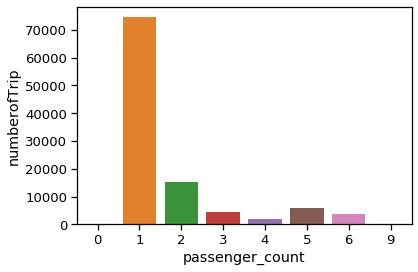

In [122]:
q= sns.barplot(data=passecount_dist.toPandas(), x="passenger_count", y= "numberofTrip")
plt.show(q)

1. Using these boundaries, **filter the 2015 data** (using pickup and dropoff longitude and latitude) and count the number of trips for each value of `passenger_count` and make a plot of that.

Trips with $0$ or larger than $7$ passengers are pretty rare.
We suspect these to be outliers. 
We need to explore these trips further in order order to understand what might be wrong
with them

1. What's special with trips with zero passengers?
1. What's special with trips with more than $6$ passengers?
1. What is the largest distance travelled during this month? Is it the first taxi on the moon?
1. Plot the distribution of the `trip_distance` (using an histogram for instance) during year 2105. Focus on trips with non-zero trip distance and trip distance less than 30 miles.

In [123]:
#What's special with trips with zero passengers?

# despite there are 0 passengers, but the trip_distance and total_amount is mentioned

df_2015_01.createOrReplaceTempView("table")
query3 = ("SELECT *  FROM table WHERE passenger_count=0 ")
ggg=spark.sql(query3)
ggg.head()

Row(VendorID=1, tpep_pickup_datetime=datetime.datetime(2015, 1, 30, 19, 23, 4), tpep_dropoff_datetime=datetime.datetime(2015, 1, 30, 19, 33, 1), passenger_count=0, trip_distance=1.6, pickup_longitude=-73.95824432373047, pickup_latitude=40.76865768432617, RatecodeID=1, store_and_fwd_flag='N', dropoff_longitude=-73.9826431274414, dropoff_latitude=40.77338409423828, payment_type=2, fare_amount=9.0, extra=1.0, mta_tax=0.5, tip_amount=0.0, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=10.8)

In [124]:
#What is the largest distance travelled during this month?
df_2015_01.createOrReplaceTempView("table")
query4 = ("SELECT max(trip_distance) FROM table ")
ggg=spark.sql(query4)
ggg.head()

Row(max(trip_distance)=181.4)

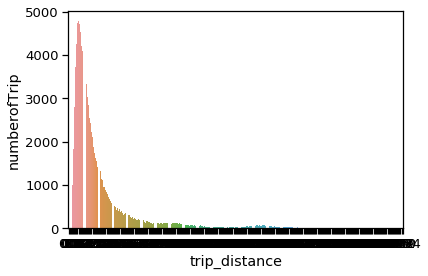

In [125]:
#the distribution of the trip_distance 

#filter:
df_2015_01.createOrReplaceTempView("table")
query5 = ("SELECT * FROM table WHERE trip_distance > 0 and trip_distance < 30000 ")
df_2015_011=spark.sql(query5)

df_2015_011.createOrReplaceTempView("table")
query3 = ("SELECT count(*) AS numberofTrip,ROUND(trip_distance,1)AS trip_distance FROM table GROUP BY ROUND(trip_distance,1)")
tripdistanc_dist=spark.sql(query3)

p= sns.barplot(data=tripdistanc_dist.toPandas(), x="trip_distance", y= "numberofTrip")
plt.show(p)

Let's look at what Spark does for these computations

1. Use the `explain` method or have a look at the [Spark UI](http://localhost:4040/SQL/) to analyze the job. You should be able to assess 
    - Parsed Logical Plan
    - Analyzed Logical Plan
    - Optimized Logical Plan
    - Physical Plan
1. Do the Analyzed Logical Plan and Optimized Logical Plan differ? Spot the differences if any. How would a RDBMS proceed with such a query?
1. How does the physical plan differ from the Optimized Logical Plan? What are the keywords you would not expects in a RDBMS? What is their meaning? 
1. Inspect the stages on [Spark UI](http://localhost:4040/stages/stage). How many *stages* are necessary to complete the Spark job? What are the roles of `HashAggregate` and `Exchange hashpartitioning`?
1. Does the physical plan perform `shuffle` operations? If yes how many?
1. What are tasks with respect to stages (in Spark language)? How many tasks are your stages made of?

In [126]:
passecount_dist.explain(True)

== Parsed Logical Plan ==
'Aggregate ['passenger_count], ['count(1) AS numberofTrip#1365, 'passenger_count]
+- 'UnresolvedRelation `table`

== Analyzed Logical Plan ==
numberofTrip: bigint, passenger_count: int
Aggregate [passenger_count#1298], [count(1) AS numberofTrip#1365L, passenger_count#1298]
+- SubqueryAlias `table`
   +- Project [VendorID#1295, tpep_pickup_datetime#1296, tpep_dropoff_datetime#1297, passenger_count#1298, trip_distance#1299, pickup_longitude#1300, pickup_latitude#1301, RatecodeID#1302, store_and_fwd_flag#1303, dropoff_longitude#1304, dropoff_latitude#1305, payment_type#1306, fare_amount#1307, extra#1308, mta_tax#1309, tip_amount#1310, tolls_amount#1311, improvement_surcharge#1312, total_amount#1313]
      +- Filter (((pickup_longitude#1300 < cast(-73.70 as double)) && (pickup_longitude#1300 > cast(-74.10 as double))) && ((pickup_latitude#1301 > cast(40.58 as double)) && (pickup_latitude#1301 < cast(40.90 as double))))
         +- SubqueryAlias `table`
           

2. The Analysed logical Plan is not different from Optimized Logical Plan 

3. The differences wetween phisical plan and optimized logical plan are :


#*(2) HashAggregate(keys=[passenger_count#254], functions=[count(1)], output=[numberofTrip#308L, passenger_count#254])
   #+- Exchange hashpartitioning(passenger_count#254, 200)
   #+- *(1) HashAggregate(keys=[passenger_count#254], functions=[partial_count(1)], output=[passenger_count#254, count#319L])

the key word are hashAggregate and hashpartitioning 


Now, compute the following and produce relevant plots:

1. Break down the trip distance distribution for each day of week
1. Count the number of distinct pickup location
1. Compute and display tips and profits as a function of the pickup location

In [128]:
import datetime  
from datetime import date
import calendar 
from pyspark.sql.functions import col
from pyspark.sql.functions import date_format

df_2015_011=df_2015_011.withColumn("week_day", date_format(col("tpep_pickup_datetime"), "EEEE"))
df_2015_011.head()

Row(VendorID=2, tpep_pickup_datetime=datetime.datetime(2015, 1, 23, 18, 44, 27), tpep_dropoff_datetime=datetime.datetime(2015, 1, 23, 18, 56, 4), passenger_count=1, trip_distance=2.94, pickup_longitude=-73.99427032470703, pickup_latitude=40.71967315673828, RatecodeID=1, store_and_fwd_flag='N', dropoff_longitude=-73.97103118896484, dropoff_latitude=40.69577407836914, payment_type=1, fare_amount=11.5, extra=1.0, mta_tax=0.5, tip_amount=2.0, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=15.3, week_day='Friday')

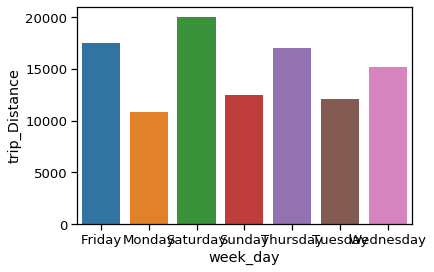

In [130]:
#Break down the trip distance distribution for each day of week

pp= df_2015_011.toPandas().groupby('week_day').trip_distance.count()
sns.barplot(pp.index, pp.values)
plt.ylabel('trip_Distance')
plt.show()


In [131]:
#Count the number of distinct pickup location

df_2015_011.select('pickup_longitude').distinct().count()
df_2015_011.select('pickup_latitude').distinct().count()

25961

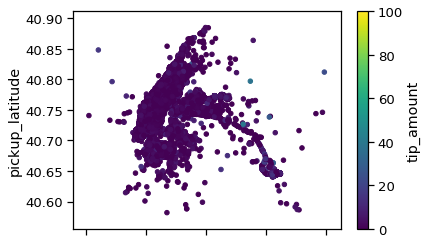

In [132]:
#Compute and display tips and profits as a function of the pickup location
#tip :

df_2015_011.createOrReplaceTempView("table")
query7 = ("SELECT pickup_longitude,pickup_latitude,tip_amount FROM table")
tip_locat=spark.sql(query7)


tip_locat.toPandas().plot.scatter(x='pickup_longitude',y='pickup_latitude',c='tip_amount',colormap='viridis')

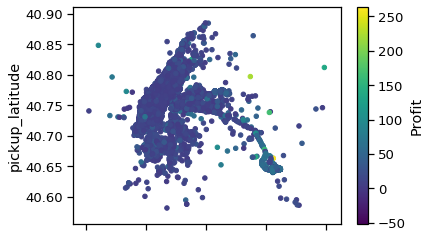

In [133]:
#profit
df_2015_011=df_2015_011.withColumn("Profit",df_2015_011.tip_amount+df_2015_011.fare_amount)

df_2015_011.createOrReplaceTempView("table")
query8 = ("SELECT pickup_longitude,pickup_latitude,Profit FROM table")
profi_locat=spark.sql(query8)

profi_locat.toPandas().plot.scatter(x='pickup_longitude',y='pickup_latitude',c='Profit',colormap='viridis')

# Investigate one month of trips data in 2015 and 2018

 Consider one month of trips data from `yellow` taxis for each year

1. Filter and cache/persist the result

## Assessing seasonalities and looking at time series

Compute and plot the following time series indexed by day of the week and hour of day:

1. The number of pickups
1. The average fare
1. The average trip duration
1. Plot the average number of ongoing trips

## Rides to the airports

In order to find the longitude and lattitude of JFK and Newark airport as well as the longitude and magnitudes 
of Manhattan, you can use a service like [geojson.io](http://geojson.io/).
Plot the following time series, indexed the day of the week and hour of the day

1. Median duration of taxi trip leaving Midtown (Southern Manhattan) headed for JFK Airport
1. Median taxi duration of trip leaving from JFK Airport to Midtown (Southern Manhattan)

## Geographic information

For this, you will need to find tools to display maps and to build choropeth maps.
We let you look and find relevant tools to do this.

1. Build a heatmap where color is a function of
    1. number of `pickups`
    2. number of `dropoffs`
    3. number of `pickups` with dropoff at some airport (JFK, LaGuardia, Newark)
2. Build a choropeth map where color is a function of
    1. number of pickups in the area
    1. ratio of number of payments by card/number of cash payments for pickups in the area
    2. ratio of total fare/trip duration for dropoff in the area
3. Build an interactive chorophet with a slider allowing the user to select an `hour of day` and where the color is a function of
    1. average number of dropoffs in the area during that hour the day
    2. average ratio of tip over total fare amount for pickups in the area at given hour of the day

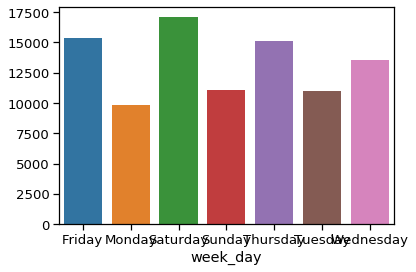

In [134]:
#The number of pickups

df_2015_011.createOrReplaceTempView("table")
query8 = ("SELECT count(*) AS numberofpickups ,ROUND(pickup_latitude, 4) as lat, ROUND(pickup_longitude, 4) as log,week_day FROM table GROUP BY log,lat, week_day")
nb_pick=spark.sql(query8)
#nb_pick.show()

yy = nb_pick.toPandas().groupby('week_day').numberofpickups.count()
sns.barplot(yy.index, yy.values)
plt.show()


#p= sns.barplot(data=nb_pick.toPandas(), x="week_day", y= "numberofpickups")
#plt.show(p)

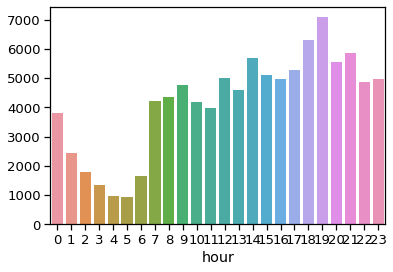

In [135]:
# by hour 
from pyspark.sql.functions import hour

df_2015_011=df_2015_011.withColumn("hour", hour(col("tpep_pickup_datetime")))


df_2015_011.createOrReplaceTempView("table")
query8 = ("SELECT count(*) AS numberofpickups,hour,ROUND(pickup_latitude, 4) as lat, ROUND(pickup_longitude, 4) as log FROM table GROUP BY log,lat,hour")
nb_pick_h=spark.sql(query8)

yy = nb_pick_h.toPandas().groupby('hour').numberofpickups.count()
sns.barplot(yy.index, yy.values)
plt.show()


#p= sns.barplot(data=nb_pick_h.toPandas(), x="hour", y= "numberofpickups")
#plt.show(p)

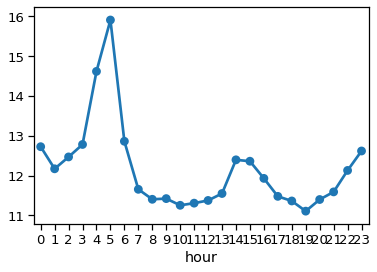

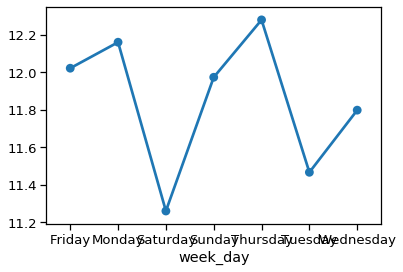

In [139]:

#The average fare

df_2015_011.createOrReplaceTempView("table")
query8 = ("SELECT fare_amount,hour,week_day FROM table")
df_2015_01_=spark.sql(query8)
#df_2015_01_.show()

xx = df_2015_01_.toPandas().groupby('hour').fare_amount.mean()
sns.pointplot(xx.index, xx.values)
plt.show()

yy = df_2015_01_.toPandas().groupby('week_day').fare_amount.mean()
sns.pointplot(yy.index, yy.values)
plt.show()


In [140]:
from pyspark.sql.types import LongType
from pyspark.sql.functions import to_timestamp

#the average trip duration

df_2015_011.createOrReplaceTempView("table")
query8 = ("SELECT tpep_pickup_datetime,tpep_dropoff_datetime,hour,week_day FROM table")
nn=spark.sql(query8)

df_2015_0111=nn.withColumn("tpep_pickup_datetime",to_timestamp(col("tpep_pickup_datetime"),"HH:mm:ss.SSS"))\
     .withColumn("tpep_dropoff_datetime",to_timestamp(col("tpep_dropoff_datetime"),"HH:mm:ss.SSS"))\
     .withColumn("DiffInSeconds",col("tpep_dropoff_datetime").cast(LongType()) - col("tpep_pickup_datetime").cast(LongType()))
#df_2015_0111.show()

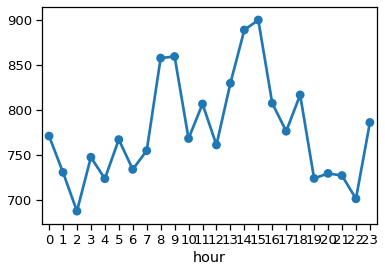

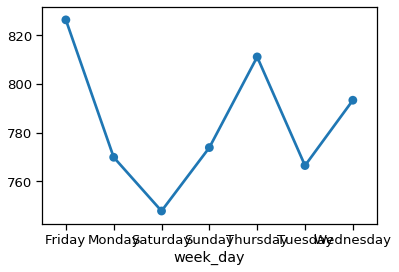

In [141]:
df_2015_0111.createOrReplaceTempView("table")
query8 = ("SELECT DiffInSeconds AS trip_duration,hour,week_day FROM table")
ll=spark.sql(query8)

vv = ll.toPandas().groupby('hour').trip_duration.mean()
sns.pointplot(vv.index, vv.values)
plt.show()


dd= ll.toPandas().groupby('week_day').trip_duration.mean()
sns.pointplot(dd.index, dd.values)
plt.show()



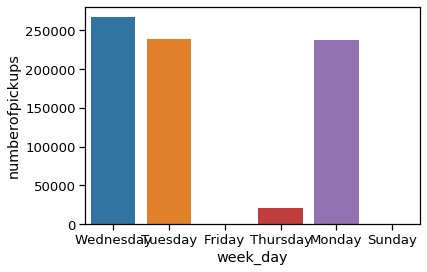

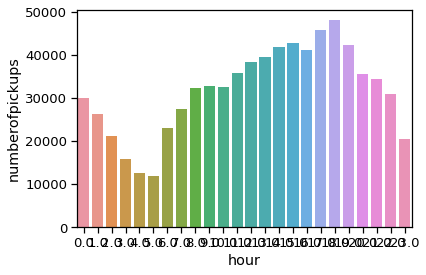

In [143]:
#for year 2018:

df_2018_01=df_2018_01.withColumn("hour", hour(col("tpep_pickup_datetime")))
df_2018_01=df_2018_01.withColumn("week_day", date_format(col("tpep_pickup_datetime"), "EEEE"))

#The number of pickups:

#by day of week:
df_2018_01.createOrReplaceTempView("table")
query8 = ("SELECT count(*) AS numberofpickups,week_day FROM table GROUP BY week_day")
nb_pick18=spark.sql(query8)
#nb_pick18.show()

p= sns.barplot(data=nb_pick18.toPandas(), x="week_day", y= "numberofpickups")
plt.show(p)

# by hour 
from pyspark.sql.functions import hour

df_2018_01=df_2018_01.withColumn("hour", hour(col("tpep_pickup_datetime")))


df_2018_01.createOrReplaceTempView("table")
query8 = ("SELECT count(*) AS numberofpickups,hour FROM table GROUP BY hour")
nb_pick_h18=spark.sql(query8)


p= sns.barplot(data=nb_pick_h18.toPandas(), x="hour", y= "numberofpickups")
plt.show(p)

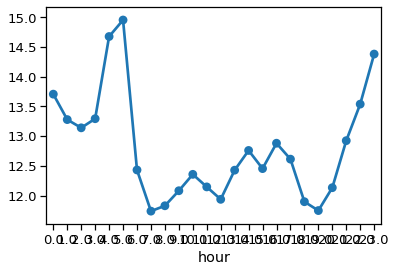

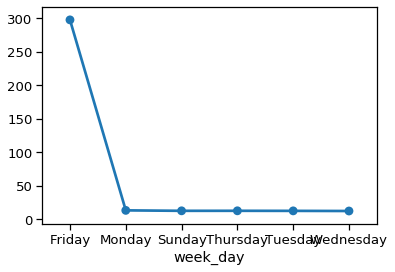

In [144]:
#The average fare
df_2018_01.createOrReplaceTempView("table")
query8 = ("SELECT fare_amount,hour,week_day FROM table")
df_2018_01_=spark.sql(query8)

xx = df_2018_01_.toPandas().groupby('hour').fare_amount.mean()
sns.pointplot(xx.index, xx.values)
plt.show()

yy = df_2018_01_.toPandas().groupby('week_day').fare_amount.mean()
sns.pointplot(yy.index, yy.values)
plt.show()

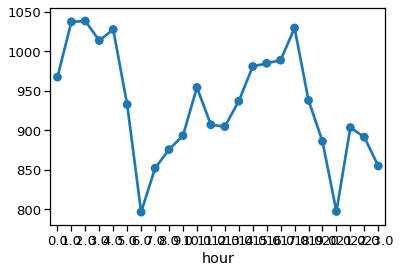

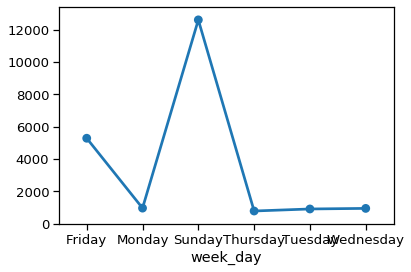

In [145]:
from pyspark.sql.types import LongType
from pyspark.sql.functions import to_timestamp

#the average trip duration

df_2018_01.createOrReplaceTempView("table")
query8 = ("SELECT tpep_pickup_datetime,tpep_dropoff_datetime,hour,week_day FROM table")
nn=spark.sql(query8)

df_2018_011=nn.withColumn("tpep_pickup_datetime",to_timestamp(col("tpep_pickup_datetime"),"HH:mm:ss.SSS"))\
     .withColumn("tpep_dropoff_datetime",to_timestamp(col("tpep_dropoff_datetime"),"HH:mm:ss.SSS"))\
     .withColumn("DiffInSeconds",col("tpep_dropoff_datetime").cast(LongType()) - col("tpep_pickup_datetime").cast(LongType()))
#df_2018_011.show()

df_2018_011.createOrReplaceTempView("table")
query8 = ("SELECT DiffInSeconds AS trip_duration,hour,week_day FROM table")
ll=spark.sql(query8)

vv = ll.toPandas().groupby('hour').trip_duration.mean()
sns.pointplot(vv.index, vv.values)
plt.show()


dd= ll.toPandas().groupby('week_day').trip_duration.mean()
sns.pointplot(dd.index, dd.values)
plt.show()


In [ ]:
#4.2  Rides to the airports: 

In [146]:
#year 2015



JFK_lon_min = -73.79422187805174
JFK_lon_max =  -73.77585411071777
JFK_lat_max = 40.65147128144057
JFK_lat_min = 40.639227866411176
New_lon_min = -74.18998718261719
New_lon_max = -74.17110443115234
New_lat_max = 40.69521661351714
New_lat_min = 40.685389433327266
SM_lon_max = -73.98983001708984
SM_lon_min = -74.00871276855469
SM_lat_max =  40.77976151788258
SM_lat_min = 40.700682761880564

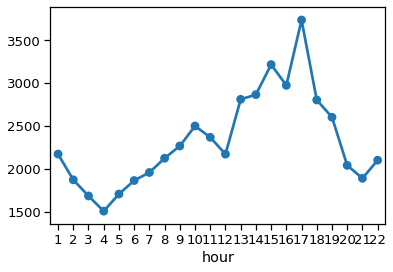

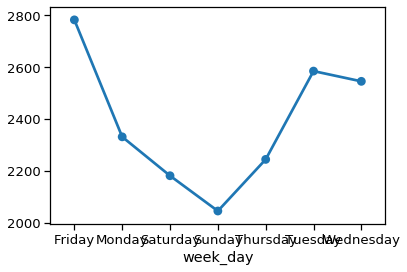

In [147]:
#Median duration of taxi trip leaving Midtown (Southern Manhattan) headed for JFK Airport :

df_2015_011.createOrReplaceTempView("table")
query = "SELECT * FROM table WHERE  pickup_latitude > 40.700682761880564 and pickup_latitude < 40.77976151788258 and pickup_longitude > -74.00871276855469 and pickup_longitude < -73.98983001708984 and dropoff_longitude < -73.77585411071777  and dropoff_longitude > -73.79422187805174 and dropoff_latitude > 40.639227866411176 and dropoff_latitude < 40.65147128144057 "
uu=spark.sql(query)
uu.head()

uu.createOrReplaceTempView("table")
query8 = ("SELECT tpep_pickup_datetime,tpep_dropoff_datetime,hour,week_day FROM table")
nn=spark.sql(query8)

df_2015_01111=nn.withColumn("tpep_pickup_datetime",to_timestamp(col("tpep_pickup_datetime"),"HH:mm:ss.SSS"))\
     .withColumn("tpep_dropoff_datetime",to_timestamp(col("tpep_dropoff_datetime"),"HH:mm:ss.SSS"))\
     .withColumn("DiffInSeconds",col("tpep_dropoff_datetime").cast(LongType()) - col("tpep_pickup_datetime").cast(LongType()))

df_2015_01111.createOrReplaceTempView("table")
query8 = ("SELECT DiffInSeconds AS trip_duration,hour,week_day FROM table")
mm=spark.sql(query8)
#mm.show()

vv = mm.toPandas().groupby('hour').trip_duration.median()
sns.pointplot(vv.index, vv.values)
plt.show()


dd= mm.toPandas().groupby('week_day').trip_duration.median()
sns.pointplot(dd.index, dd.values)
plt.show()


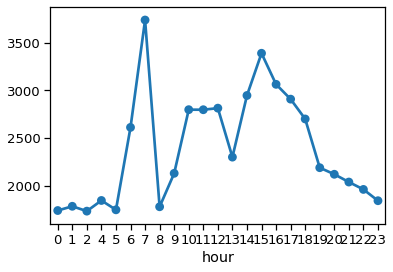

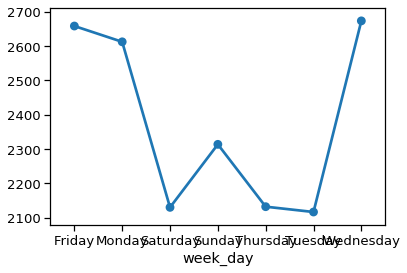

In [148]:
#Median taxi duration of trip leaving from JFK Airport to Midtown (Southern Manhattan):

df_2015_011.createOrReplaceTempView("table")
query = "SELECT * FROM table WHERE  dropoff_latitude > 40.700682761880564 and dropoff_latitude < 40.77976151788258 and dropoff_longitude > -74.00871276855469 and dropoff_longitude < -73.98983001708984 and pickup_longitude < -73.77585411071777  and pickup_longitude > -73.79422187805174 and pickup_latitude > 40.639227866411176 and pickup_latitude < 40.65147128144057 "
uu=spark.sql(query)
uu.head()

uu.createOrReplaceTempView("table")
query8 = ("SELECT tpep_pickup_datetime,tpep_dropoff_datetime,hour,week_day FROM table")
nn=spark.sql(query8)

df_2015_01111=nn.withColumn("tpep_pickup_datetime",to_timestamp(col("tpep_pickup_datetime"),"HH:mm:ss.SSS"))\
     .withColumn("tpep_dropoff_datetime",to_timestamp(col("tpep_dropoff_datetime"),"HH:mm:ss.SSS"))\
     .withColumn("DiffInSeconds",col("tpep_dropoff_datetime").cast(LongType()) - col("tpep_pickup_datetime").cast(LongType()))

df_2015_01111.createOrReplaceTempView("table")
query8 = ("SELECT DiffInSeconds AS trip_duration,hour,week_day FROM table")
mm=spark.sql(query8)
#mm.show()

vv = mm.toPandas().groupby('hour').trip_duration.median()
sns.pointplot(vv.index, vv.values)
plt.show()


dd= mm.toPandas().groupby('week_day').trip_duration.median()
sns.pointplot(dd.index, dd.values)
plt.show()



In [45]:
# 4.3

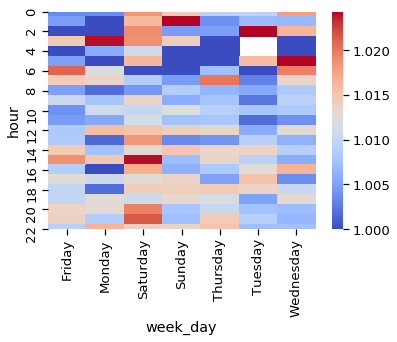

In [149]:
#number of pickups

df_2015_011.createOrReplaceTempView("table")
query8 = ("SELECT count(*) AS numberofpickups ,ROUND(pickup_latitude, 4) as lat, ROUND(pickup_longitude, 4) as log,week_day, hour FROM table GROUP BY week_day,hour, log,lat")
nb_pick=spark.sql(query8)

df1 = pd.pivot_table(data=nb_pick.toPandas(),
                    index='hour',
                    values='numberofpickups',
                    columns='week_day')

p1 = sns.heatmap(df1, cmap='coolwarm', robust=True)

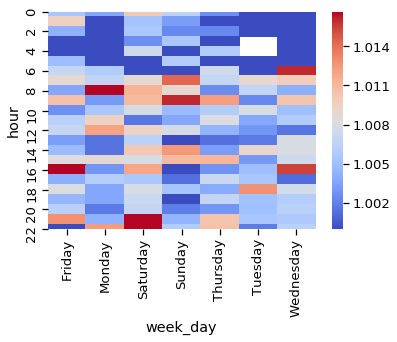

In [150]:
#number of dropoffs

df_2015_011.createOrReplaceTempView("table")
query8 = ("SELECT count(*) AS numberofdropoff ,ROUND(dropoff_latitude, 4) as lat, ROUND(dropoff_longitude, 4) as log,week_day, hour FROM table GROUP BY week_day,hour, log,lat")
nb_dropoff=spark.sql(query8)

df2 = pd.pivot_table(data=nb_dropoff.toPandas(),
                    index='hour',
                    values='numberofdropoff',
                    columns='week_day')

p2 = sns.heatmap(df2, cmap='coolwarm', robust=True)

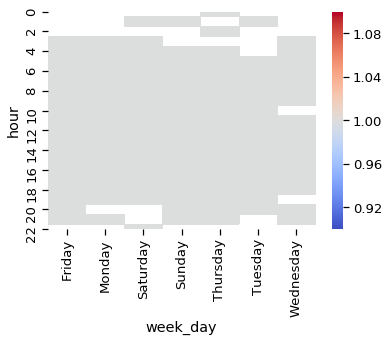

In [151]:
#number of pickups with dropoff at some airport (JFK, LaGuardia, Newark)

# number of pickups with dropoff at JFK

JFK_lon_min = -73.79422187805174
JFK_lon_max =  -73.77585411071777
JFK_lat_max = 40.65147128144057
JFK_lat_min = 40.639227866411176

df_2015_011.createOrReplaceTempView("table")
query8 = ("SELECT count(*) AS numberofpickups ,ROUND(pickup_latitude, 4) as lat, ROUND(pickup_longitude, 4) as log,week_day, hour FROM table WHERE dropoff_latitude BETWEEN 40.639227866411176 AND 40.65147128144057 AND dropoff_longitude BETWEEN -73.79422187805174 AND -73.77585411071777 GROUP BY week_day,hour, log,lat")
nb_pick=spark.sql(query8)

df3 = pd.pivot_table(data=nb_pick.toPandas(),
                    index='hour',
                    values='numberofpickups',
                    columns='week_day')

p3 = sns.heatmap(df3, cmap='coolwarm', robust=True)

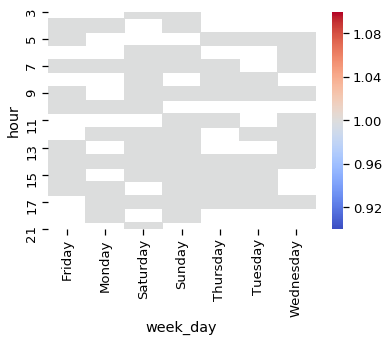

In [152]:
#number of pickups with dropoff at New

New_lon_min = -74.18998718261719
New_lon_max = -74.17110443115234
New_lat_max = 40.69521661351714
New_lat_min = 40.685389433327266

df_2015_011.createOrReplaceTempView("table")
query8 = ("SELECT count(*) AS numberofpickups ,ROUND(pickup_latitude, 4) as lat, ROUND(pickup_longitude, 4) as log,week_day, hour FROM table WHERE dropoff_latitude BETWEEN 40.685389433327266 AND 40.69521661351714 AND dropoff_longitude BETWEEN -74.18998718261719 AND -74.17110443115234 GROUP BY week_day,hour, log,lat")
nb_pick=spark.sql(query8)

df4 = pd.pivot_table(data=nb_pick.toPandas(),
                    index='hour',
                    values='numberofpickups',
                    columns='week_day')

p4 = sns.heatmap(df4, cmap='coolwarm', robust=True)

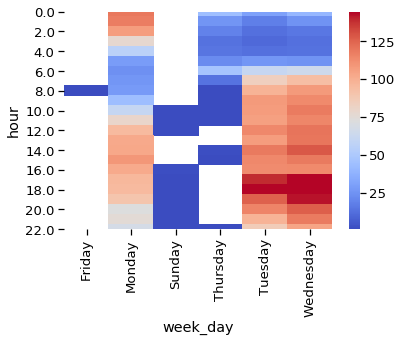

In [153]:
# year 2018
#number of pickups 

df_2018_01.createOrReplaceTempView("table")
query8 = ("SELECT count(*) AS numberofpickups ,PULocationID,week_day, hour FROM table GROUP BY PULocationID,week_day,hour")
nb_pick=spark.sql(query8)

df5 = pd.pivot_table(data=nb_pick.toPandas(),
                    index='hour',
                    values='numberofpickups',
                    columns='week_day')

p5 = sns.heatmap(df5, cmap='coolwarm', robust=True)

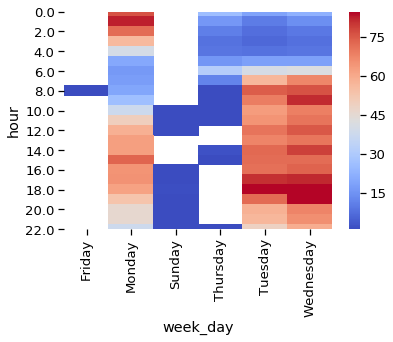

In [154]:
# number of dropoffs 

df_2018_01.createOrReplaceTempView("table")
query8 = ("SELECT count(*) AS numberofpickups ,DOLocationID,week_day, hour FROM table GROUP BY DOLocationID,week_day,hour")
nb_pick=spark.sql(query8)

df6 = pd.pivot_table(data=nb_pick.toPandas(),
                    index='hour',
                    values='numberofpickups',
                    columns='week_day')

p6 = sns.heatmap(df6, cmap='coolwarm', robust=True)